# Loading and preprocessing data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
sales = pd.read_csv('sales.csv')
visits = pd.read_csv('visits.csv')

In [3]:
sales.head(3)

,Unnamed: 0,uid,timestamp,source,browser,flag,price
0,386479,50b9d220-c62d-4b85-8898-2043700db4ef,2019-01-05,criteo,internet_explorer,0,2277
1,193643,f215ff2d-26f9-425e-9337-b2417f389384,2019-01-05,jewio,google_chrome,1,3612
2,412809,164abdaf-5fd8-4230-9230-e1e5e105ca0a,2019-01-05,criteo,google_chrome,1,16315


In [4]:
visits.head(3)

,Unnamed: 0,uid,timestamp,source,browser,flag
0,0,f448a34a-67da-4f56-95c7-e9afe9bd54cf,2019-01-06,organic,opera_mini,0
1,1,c891f62f-ff1a-476d-a5a4-f2738c5fa991,2019-01-11,criteo,internet_explorer,1
2,2,36a58b94-bf4a-440c-bfc4-f82acb8824f3,2019-01-18,direct,edge,0


Join data to calculate conversion rate.

In [5]:
all_data = visits.merge(sales[['uid','timestamp', 'price']], how='left', on=['uid', 'timestamp'])
all_data.price = np.where(np.isnan(all_data.price),
                        0, all_data.price)
all_data.head(3)

,Unnamed: 0,uid,timestamp,source,browser,flag,price
0,0,f448a34a-67da-4f56-95c7-e9afe9bd54cf,2019-01-06,organic,opera_mini,0,0.0
1,1,c891f62f-ff1a-476d-a5a4-f2738c5fa991,2019-01-11,criteo,internet_explorer,1,0.0
2,2,36a58b94-bf4a-440c-bfc4-f82acb8824f3,2019-01-18,direct,edge,0,12480.0


Split all_data to two datasets by flag.

In [6]:
a_data = all_data[(all_data.flag==0)]
b_data = all_data[(all_data.flag==1)]

Split sales to two datasets by flag.

In [7]:
a_sales = sales[(sales.flag==0)]
b_sales = sales[(sales.flag==1)]

# Data investigation

Draw boxplots to to visually compare two distributions.

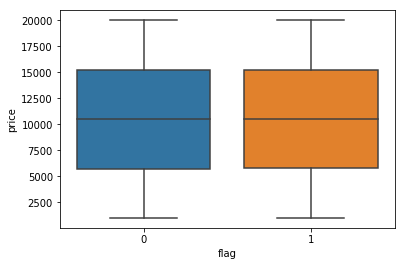

In [8]:
ax = sns.boxplot(x="flag", y="price", data=sales)

As we see, price distributions are quite similar. There are no outliers.

In [9]:
a_visits = a_data.shape[0]
b_visits = b_data.shape[0]
a_purchases = a_data[(a_data.price>0)].shape[0]
b_purchases = b_data[(b_data.price>0)].shape[0]

In [10]:
print('Default button visits: ' + str(a_visits))
print('New button visits: ' + str(b_visits))

Default button visits: 485003
New button visits: 494383


In [11]:
a_visitors = a_data.uid.nunique()
b_visitors = b_data.uid.nunique()

In [12]:
print('Default button visitors: ' + str(a_visitors))
print('New button visitors: ' + str(b_visitors))

Default button visitors: 485003
New button visitors: 494383


There were more unique visitors and number of visits for the new botton.
Let's calculate ARPU by date.

In [13]:
a_ARPU = pd.DataFrame(a_sales.groupby(by='timestamp').price.sum()).merge(
    pd.DataFrame(a_sales.groupby(by='timestamp').uid.nunique()), 
    on='timestamp')
a_ARPU['ARPU'] = a_ARPU['price']/a_ARPU['uid']
a_ARPU.head(3)

,price,uid,ARPU
timestamp,,,
2019-01-01,97391986,9298,10474.509142
2019-01-02,97462257,9245,10542.158680
2019-01-03,98192654,9343,10509.756395


In [14]:
b_ARPU = pd.DataFrame(b_sales.groupby(by='timestamp').price.sum()).merge(
    pd.DataFrame(b_sales.groupby(by='timestamp').uid.nunique()), 
    on='timestamp')
b_ARPU['ARPU'] = b_ARPU['price']/b_ARPU['uid']
b_ARPU.head(3)

,price,uid,ARPU
timestamp,,,
2019-01-01,97829661,9287,10534.043394
2019-01-02,100018750,9431,10605.317570
2019-01-03,101388465,9643,10514.203567


Draw sales per visitor change by date.

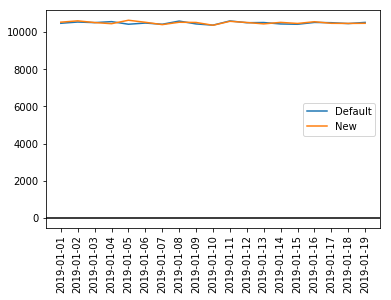

In [15]:
fig, ax = plt.subplots()
ax.plot(a_ARPU['ARPU'], label='Default')
ax.plot(b_ARPU['ARPU'], label='New')
plt.xticks(rotation=90)
ax.axhline(y=0, color='k')
ax.legend()
plt.show()

Calculate if sales per visitors are simular for different browsers or new button have different impact on them.

In [16]:
sales_per_browser = pd.DataFrame(sales.groupby(by=['browser', 'flag']).price.sum()).merge(
    pd.DataFrame(sales.groupby(by=['browser', 'flag']).uid.nunique()), 
    on=['browser', 'flag'])
sales_per_browser['% price per browser'] = sales_per_browser.price /sales_per_browser.uid
sales_per_browser
sales_per_browser.groupby(level=0).transform(lambda x: round(x/x.sum()*100, 2))['% price per browser']

browser            flag
edge               0       49.98
                   1       50.02
google_chrome      0       49.90
                   1       50.10
internet_explorer  0       49.99
                   1       50.01
mozilla_firefox    0       49.97
                   1       50.03
opera              0       50.00
                   1       50.00
opera_mini         0       49.96
                   1       50.04
safari             0       49.86
                   1       50.14
yandex_browser     0       50.07
                   1       49.93
Name: % price per browser, dtype: float64

As wee see button have quite simular effect for all browsers.

# Hypothesis testing

First let's select significance level for our test.
The significance level (alpha or α) is the probability of rejecting the null hypothesis when it is true.
I will use alpha = 0.05.

## Hypothesis 1

Null hypothesis: buttons have the same purchase conversion rate (% of visits that ended with purchase).

Let's visualize the difference between conversion rate for default and new button.

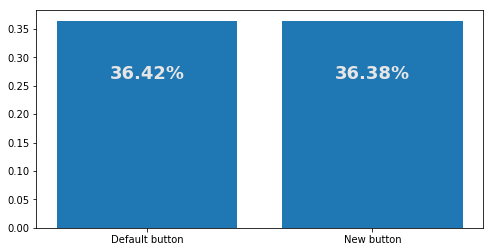

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

x = [0,1]
y = [a_purchases/a_visits, b_purchases/b_visits]
ax.bar(x, y, align='center', width=.8)
ax.set_xticks(x)
ax.set_xticklabels(['Default button', 'New button'])

for xx, yy in zip(x,y):
    ax.text(xx, yy*.7, '%0.2f%%'%(100*yy),
            ha='center', va='bottom', 
            fontdict={'size':18,'weight':'bold','color':(0.9,.9,.9)})

In [18]:
# Check that the difference in Conversion Rates is statistically significant for Alpha=0.05

from statsmodels.stats.proportion import proportions_ztest
count = np.array([a_purchases,b_purchases])
nobs = np.array([a_visits, b_visits])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = 0.3980598028710438 
 p-value = 0.690586103884811


p-value is more than 0.05. Therefore, conversion rate changed insignificantly.

## Hypothesis 2

Null hypothesis: The difference between sales for each botton is insignificant.

In [19]:
pd.DataFrame(a_sales.price.describe()).join(pd.DataFrame(b_sales.price.describe()), 
     lsuffix='_default', rsuffix='_new')

,price_default,price_new
count,176647.000000,179872.000000
mean,10490.446580,10504.782834
std,5487.484847,5485.158566
min,1000.000000,1000.000000
25%,5725.000000,5755.000000
50%,10490.000000,10494.000000
75%,15243.000000,15249.000000
max,19999.000000,19999.000000


Let's look at price distribution chart to compare.

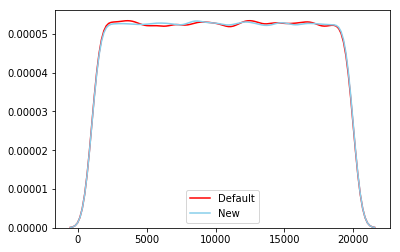

In [20]:
sns.distplot(tuple(a_sales.price), color="red", label="Default", hist=False)
sns.distplot(tuple(b_sales.price), color="skyblue", label="New", hist=False)

Distributions aren't normally distributed. We need to use non-parametric test. I will use Kolmogorov Smirnov.

In [21]:
s, p = ks_2samp(a_sales.price, b_sales.price)
print('statisctics = {s} \np-value = {p}'.format(s=s,p=p))

statisctics = 0.002646708383142543 
p-value = 0.5597548318515957


P-value is more then our significant value so null-hypothesis can't be rejected. Sales difference is insignificant.

## Hypothesis 3

Null hypothesis: ARPU is the same for both bottons.

In [22]:
a_data_cust = pd.DataFrame(a_data.groupby(by='uid').price.sum())
b_data_cust = pd.DataFrame(b_data.groupby(by='uid').price.sum())

Let's draw ARPU distribution to compare.

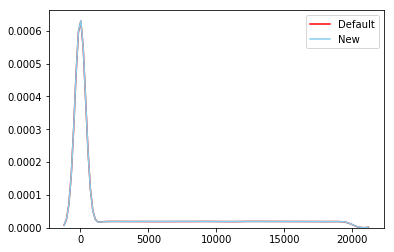

In [23]:
sns.distplot(a_data_cust, color="red", label="Default", hist=False)
sns.distplot(b_data_cust, color="skyblue", label="New", hist=False)

Data for both bottons isn't normally distributed. 
Therefore I will use Kolmogorov Smirnov test again.

In [24]:
s, p = ks_2samp(a_ARPU['ARPU'], b_ARPU['ARPU'])
print('statisctics = {s} \np-value = {p}'.format(s=s,p=p))

statisctics = 0.21052631578947373 
p-value = 0.741505714202556


P-value is more then our significant value so null-hypothesis can't be rejected. Sales difference is insignificant.

# Conclusion

We tested three hypothesis:
* Equality of Conversion rates
* Equality of sales
* Equality of ARPU

All three hypotheses can not be rejected.
So we can conclude that the difference between the buttons is insignificant.

There is no reason to change the design of the button.